# MBTI Type Prediction: Preprocessing and EDA

https://www.kaggle.com/datasnaek/mbti-type

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tqdm

In [3]:
!pip install ftfy

     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=2004ebbb2910a6a3e481267aad1de000262978e27ca818b91c975d09e719552c
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ftfy


In [9]:
import re
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import csv
from tqdm.auto import tqdm

from string import punctuation

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
pd.set_option('max_rows',1000000)
pd.set_option('max_columns',10000)
sns.set(rc={'figure.figsize':(15,10)})

## Loading data...

The raw data consists of two columns:
* `type (str)`: The author's 4-letter MBTI personality type.
* `posts (str)`: The author's post history. Posts are separated by the delimiter `|||`.

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/misc. class files/CSC713M/Project/mbti_1.csv',
    quoting=csv.QUOTE_ALL,
    dtype={'type':'category'}
    )

In [13]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


We check for NA rows.

In [14]:
df.isna().sum()

type     0
posts    0
dtype: int64

We also check for any empty strings (including pure whitespace), which we should discard.

In [15]:
df['posts'].str.match('^\s*$').sum()

0

We check out the distribution of MBTI types across authors.

In [16]:
df['type'].value_counts().describe()

count      16.000000
mean      542.187500
std       576.700756
min        39.000000
25%       146.750000
50%       251.000000
75%       786.500000
max      1832.000000
Name: type, dtype: float64

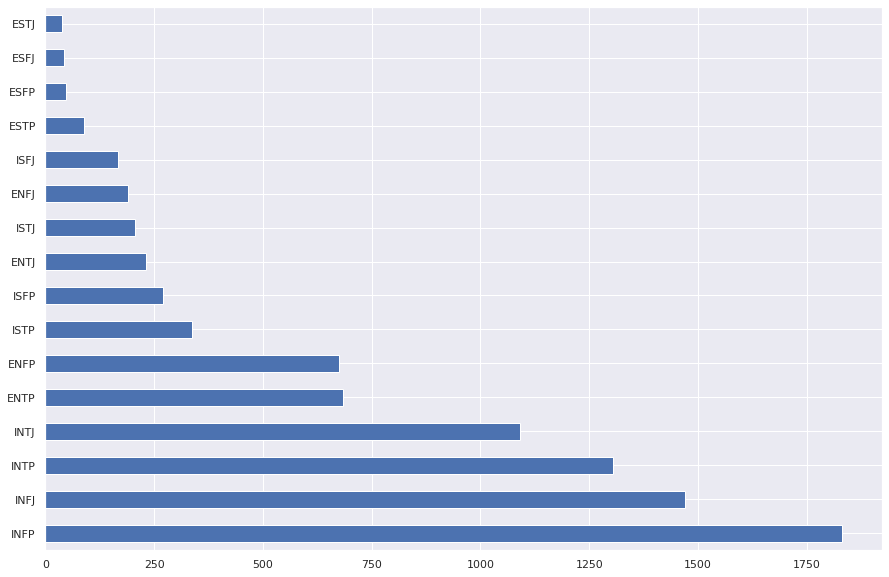

In [17]:
df['type'].value_counts().plot(kind='barh')

There seems to be a lot of imbalance among 4-letter types, but maybe it all evens out when we decompose the types? Let's take a look at the individual components (dichotomies) of each type.

In [18]:
df['E/I'] = df['type'].str.get(0).astype('category')
df['S/N'] = df['type'].str.get(1).astype('category')
df['T/F'] = df['type'].str.get(2).astype('category')
df['J/P'] = df['type'].str.get(3).astype('category')
df.head()

,type,posts,E/I,S/N,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


In [ ]:
pd.concat([df[col] for col in ['E/I', 'S/N', 'T/F', 'J/P']])

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

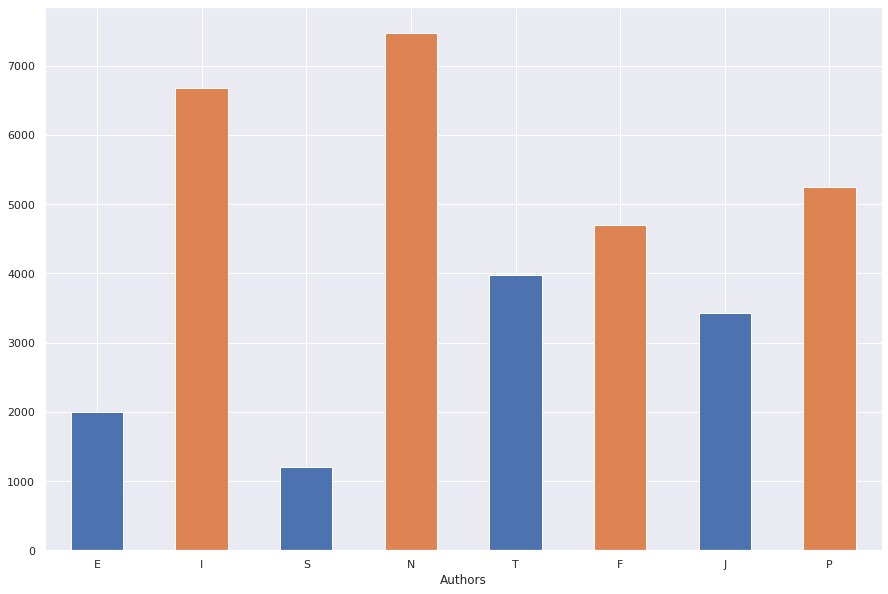

In [20]:
pd.concat([df[col] for col in ['E/I', 'S/N', 'T/F', 'J/P']])\
    .value_counts()\
    .reindex(['E', 'I', 'S', 'N', 'T', 'F', 'J', 'P'])\
    .plot(kind='bar', color=['C0', 'C1'])
plt.xlabel('Authors')
plt.xticks(rotation=0)

We note a severe author imbalance between Extraversion/Introversion and Sensing/Intuition. We may have to handle this later with data augmentation techniques.

To get a better look at our data, we split each post into its own row.

In [21]:
df = df.join(df['posts'].str.split('\s*\|\|\|+\s*').explode().rename('post')).reset_index().rename({'index': 'author'}, axis=1).drop('posts', axis=1)
df['post_original'] = df['post']
df

While the Kaggle page claims 50 posts per author, this may not be the case. We check the distribution of post counts across users.

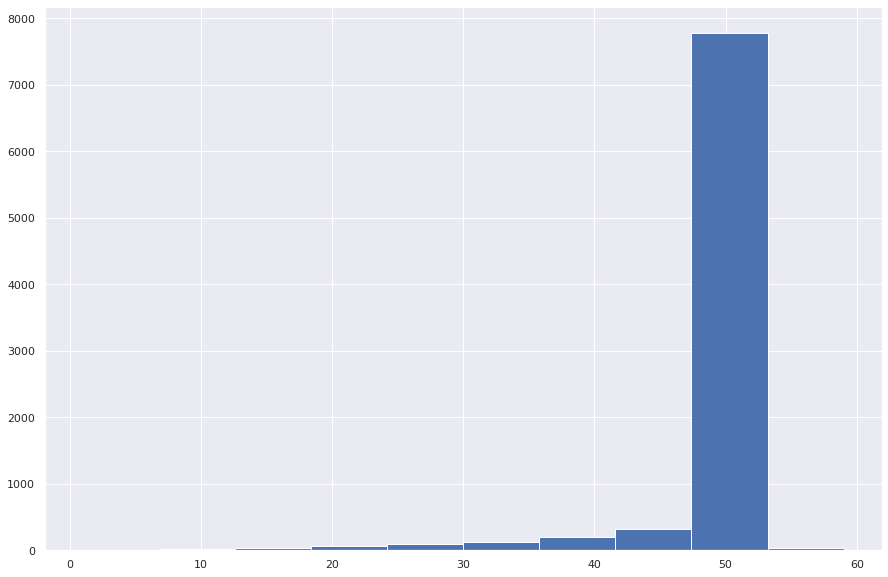

In [22]:
df.author.value_counts().hist()

While a majority of authors have at least 50 posts, there are several with less. This may pose a problem later on for our model; if it's trained to predict based on the content of 50 posts, it might not do as well predicting based on 2 or 3.

In [23]:
len(df.author.value_counts().loc[lambda x: x>=50])

7674

In [24]:
print(
    f'{len(df.author.value_counts().loc[lambda x: x>=50])/len(df.author.unique()):.2%} of authors have >= 50 posts'
)

88.46% of authors have >= 50 posts


In [ ]:
# df = df.loc[df.author.isin(df.author.value_counts().loc[lambda x: x>=50].index)]
# df.author.value_counts()

## URLs

We extract URLs from the posts.

A lot of URLs, especially from sites like YouTube and Imgur, typically aren't going to be descriptive of the actual content on the page. The long content IDs may even throw the model off later as OOV tokens if included during feature extraction. Instead, we extract the **root domain names** for each of these sites.

In [ ]:
# Borrowing regex from sacremoses
# Minor edit to ensure at least one non-period character after protocol
# urls = df['post'].str.findall(r'(?:(?:https?|ftp|rsync)://|www\.)[^\.\s]\S*').rename('urls').explode().dropna()
# urls = df['post'].str.findall(r'(?:(?:https?|ftp|rsync)://|www\.)(?:([^ /]+)\.)+').rename('urls').explode().dropna().apply(lambda x: x.split('.')[-1])
urls = df['post'].str.findall(r'(?:(?:https?|ftp|rsync)://|www\.)(?:[^ /]+\.)*([^ /]+)\.').rename('urls').explode().dropna()

# Special case: youtu.be to youtube
urls = urls.replace('youtu', 'youtube')

urls

Now that we've extracted them, we can replace the URLs with root domain tokens in the original text.

In [27]:
df['post'] = df['post'].str.replace(r'(?:(?:https?|ftp|rsync)://|www\.)(?:[^ /]+\.)*([^ /]+)\.\S+', r'<|url_\1|>')
# Special case: youtu to youtube
df['post'] = df['post'].str.replace('<|url_youtu|>', '<|url_youtube|>', regex=False)

In [ ]:
urls.value_counts()

We take a look at the distribution of URL mention count per post.

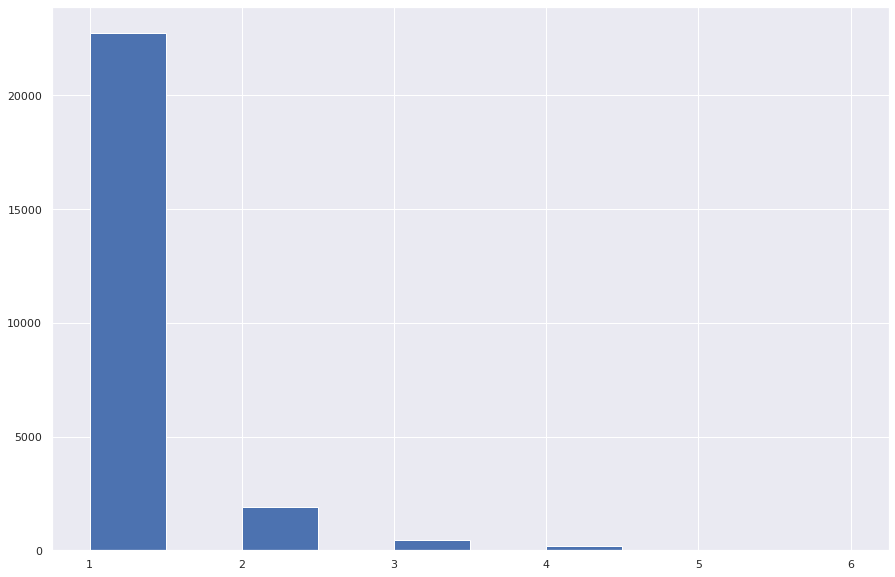

In [29]:
urls.groupby(urls.index).agg(list).apply(len).hist()

Most posts mentioning URLs will only have 1-2 URLs.

In [31]:
df = df.join(
    urls.reset_index().groupby('index').agg([Counter, 'count'])['urls'].rename({'Counter': 'urls', 'count': 'url_count'}, axis=1)
).fillna({'url_count': 0}).astype({'url_count': int})
df

ValueError: ignored

This time, let's look at the distribution of average number of URLs per message per author.

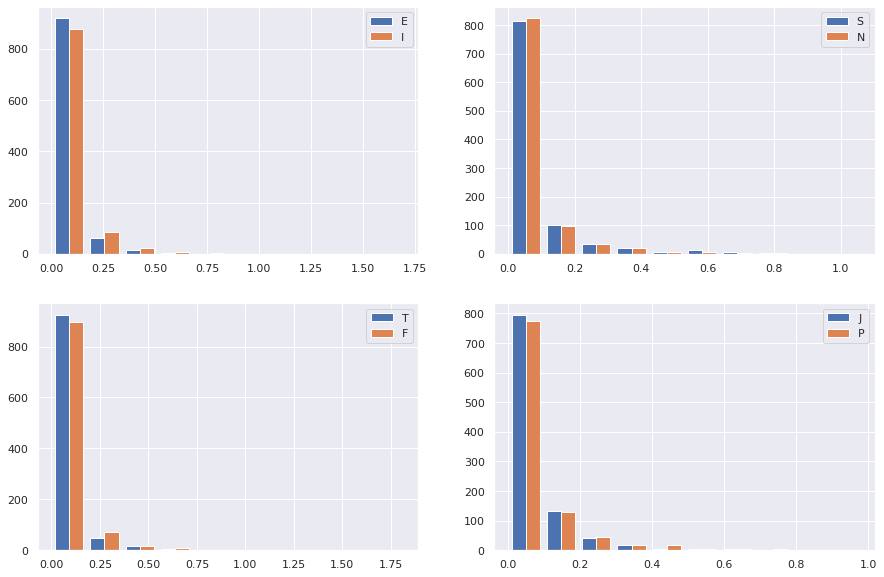

In [32]:
plt.subplot(221)
plt.hist([
    df.loc[lambda x: x['E/I']=='E'].groupby('author')['url_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['E/I']=='I'].groupby('author')['url_count'].mean().sample(1000, random_state=42)
], label=['E', 'I'])
plt.legend()

plt.subplot(222)
plt.hist([
    df.loc[lambda x: x['S/N']=='S'].groupby('author')['url_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['S/N']=='N'].groupby('author')['url_count'].mean().sample(1000, random_state=42)
], label=['S', 'N'])
plt.legend()

plt.subplot(223)
plt.hist([
    df.loc[lambda x: x['T/F']=='T'].groupby('author')['url_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['T/F']=='F'].groupby('author')['url_count'].mean().sample(1000, random_state=42)
], label=['T', 'F'])
plt.legend()

plt.subplot(224)
plt.hist([
    df.loc[lambda x: x['J/P']=='J'].groupby('author')['url_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['J/P']=='P'].groupby('author')['url_count'].mean().sample(1000, random_state=42)
], label=['J', 'P'])
plt.legend()

There's not much we can immediately identify from the histograms. However, these are based on aggregated URL counts for each post regardless of what URLs those are; we'll see later during model training if there are specific domains (e.g. YouTube, Imgur) that may serve as good features.

## Quotes

PersonalityCafe has its own notation for users quoting other users in the form of `[QUOTE=Username;ID]Text`.

In [ ]:
df.loc[df['post'].str.contains(r'\[?QUOTE\]?')]

We notice that there are start and end tags for quotes (similar to HTML tags), and that their presence is not consistent across posts. Some posts may have both, and some may only have one (start or end), resulting in incomplete tag closures. Occurrences of tags may also be malformed (missing brackets, no username/ID). This makes it challenging to get proper quote counts per post and avoid double-counting start and end tags. Thus, we only extract the presence/absence of quotes in a post regardless of number as a boolean feature.

The dataset still has the quoted users' IDs; let's remove those so the model doesn't rely on them as features later.

**Careful!** Usernames can have spaces, so don't use `\S+` inside the square brackets. Instead, accept any character until the closing bracket `]`.

In [34]:
# Replace start tags before end tags so we don't accidentally capture tags without the starting square bracket

df['post'] = df['post']\
    .str.replace(r'\[QUOTE=?(?:[^\]]*\])?', '<|quote|>')\
    .str.replace(r'\[?/QUOTE=?[^\]]*\]', '<|endquote|>')
df.loc[df['post'].str.contains('\<\|quote\|\>')].head()

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count
3450,70,INFJ,I,N,F,J,"<|quote|> yay, a lady gaga fan! Im a lady gaga...","[QUOTE=Sillia Rosa;1179305] yay, a lady gaga f...",NaN,0
3461,70,INFJ,I,N,F,J,"<|quote|>Do you believe in soul mates? Why, or...",[QUOTE=Jazzanova;1194321]Do you believe in sou...,NaN,0
5382,110,ENTP,E,N,T,P,<|quote|>I think there should be a warning wit...,[QUOTE=WMDistraction;686249]I think there shou...,NaN,0
7183,147,ENTP,E,N,T,P,<|quote|>one term government? what do you mean...,[QUOTE=afriskykiwi;4138506]one term government...,NaN,0
7184,147,ENTP,E,N,T,P,<|quote|>one term government? what do you mean...,[QUOTE=afriskykiwi;4138506]one term government...,NaN,0


In [35]:
df['has_quote'] = df['post'].str.contains(r'\<\|quote\|\>|\<\|endquote\|\>')
df.loc[df['has_quote']].head()

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count,has_quote
512,10,INFJ,I,N,F,J,It kind of sounds believable<|endquote|> You ...,It kind of sounds believable[/QUOTE] You guys...,NaN,0,True
528,10,INFJ,I,N,F,J,"Oh dear. Trees have stronger and weaker roots,...","Oh dear. Trees have stronger and weaker roots,...",NaN,0,True
3450,70,INFJ,I,N,F,J,"<|quote|> yay, a lady gaga fan! Im a lady gaga...","[QUOTE=Sillia Rosa;1179305] yay, a lady gaga f...",NaN,0,True
3461,70,INFJ,I,N,F,J,"<|quote|>Do you believe in soul mates? Why, or...",[QUOTE=Jazzanova;1194321]Do you believe in sou...,NaN,0,True
5382,110,ENTP,E,N,T,P,<|quote|>I think there should be a warning wit...,[QUOTE=WMDistraction;686249]I think there shou...,NaN,0,True


## Emoji

PersonalityCafe encodes emoji in the form `:keyword:`. This means a regex targeting emoji may capture unrelated pairs of colons (e.g. timestamps, URLs). However, since we already dealt with URLs earlier, we just need to worry about timestamps.

In [ ]:
# We place negative lookbehinds and lookaheads to prevent the regex from matching
#   when the colons are preceded or followed by digits (e.g. timestamp)
emoji = df['post'].str.lower().str.findall(r'(?<![0-9]):[-_0-9A-Za-z][-_0-9A-Za-z]+:(?![0-9])')\
    .explode()\
    .dropna()\
    .rename('emoji')
emoji

After extracting the emoji, we replace them in the original text with easier-to-capture tokens.

In [37]:
df['post'] = df['post'].str.replace(r'(?<![0-9]):([-_0-9A-Za-z][-_0-9A-Za-z]+):(?![0-9])', r'<|emoji_\1|>')
df.loc[df['post'].str.contains('\<\|emoji_\S+\|\>')].head()

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count,has_quote
14,0,INFJ,I,N,F,J,Dear ENFP: What were your favorite video game...,Dear ENFP: What were your favorite video game...,NaN,0,False
16,0,INFJ,I,N,F,J,It appears to be too late. <|emoji_sad|>,It appears to be too late. :sad:,NaN,0,False
42,0,INFJ,I,N,F,J,"Welcome to the robot ranks, person who downed ...","Welcome to the robot ranks, person who downed ...",NaN,0,False
237,4,ENTJ,E,N,T,J,Hey @MsBossyPants are you down for a debate on...,Hey @MsBossyPants are you down for a debate on...,NaN,0,False
304,6,INFJ,I,N,F,J,"Dear very bad person, Not trying to get in be...","Dear very bad person, Not trying to get in be...",NaN,0,False


In [38]:
df = df.join(
    emoji.reset_index()\
        .groupby('index')\
        .agg([Counter, 'count'])['emoji']\
        .rename({'Counter': 'emojis', 'count': 'emoji_count'}, axis=1)
).fillna({'emoji_count': 0}).astype({'emoji_count': int})
df.head()

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count,has_quote,emojis,emoji_count
0,0,INFJ,I,N,F,J,'<|url_youtube|>,'http://www.youtube.com/watch?v=qsXHcwe3krw,{'youtube': 1},1,False,NaN,0
1,0,INFJ,I,N,F,J,<|url_tumblr|>,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,{'tumblr': 1},1,False,NaN,0
2,0,INFJ,I,N,F,J,enfp and intj moments <|url_youtube|> sports...,enfp and intj moments https://www.youtube.com...,{'youtube': 2},2,False,NaN,0
3,0,INFJ,I,N,F,J,What has been the most life-changing experienc...,What has been the most life-changing experienc...,NaN,0,False,NaN,0
4,0,INFJ,I,N,F,J,<|url_youtube|> <|url_youtube|> On repeat f...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,{'youtube': 2},2,False,NaN,0


Let's look at the distribution for emoji count per post.

In [39]:
df['emoji_count'].describe()

count    421757.000000
mean          0.050344
std           0.281328
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: emoji_count, dtype: float64

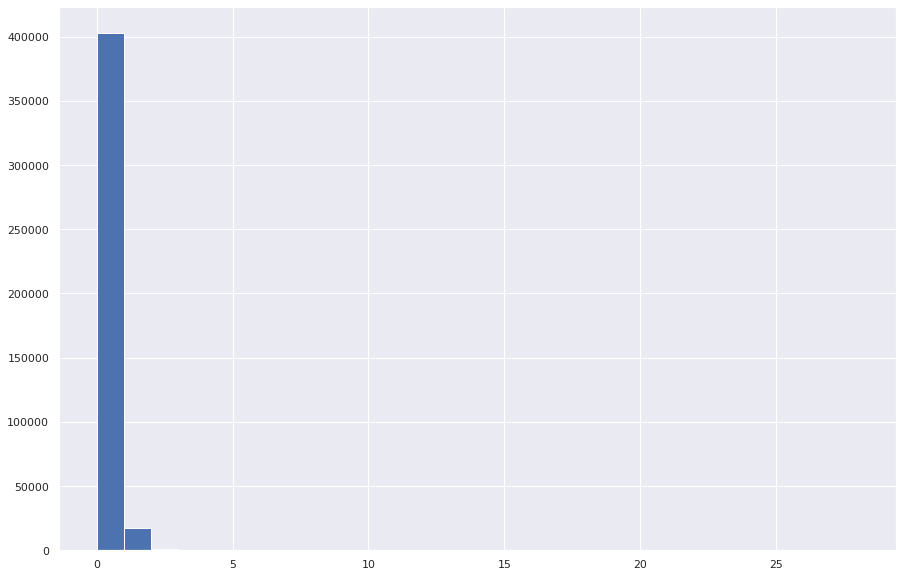

In [40]:
df['emoji_count'].hist(bins=df['emoji_count'].max())

We see that most posts will only have 0-2 emoji, but that extreme cases can go up to 28 emoji in a single post. Let's see what that looks like...

In [41]:
df.loc[df['emoji_count']==df['emoji_count'].max()]

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count,has_quote,emojis,emoji_count
306570,6314,ESFJ,E,S,F,J,<|emoji_happy|><|emoji_happy|><|emoji_happy|><...,:happy::happy::happy::happy::happy::happy::hap...,NaN,0,False,{':happy:': 28},28


The post consists solely of the `:happy:` emoji. We observe a potential feature here to use later: quantity per emoji.

Let's look at the distribution for average emoji count per post per author.

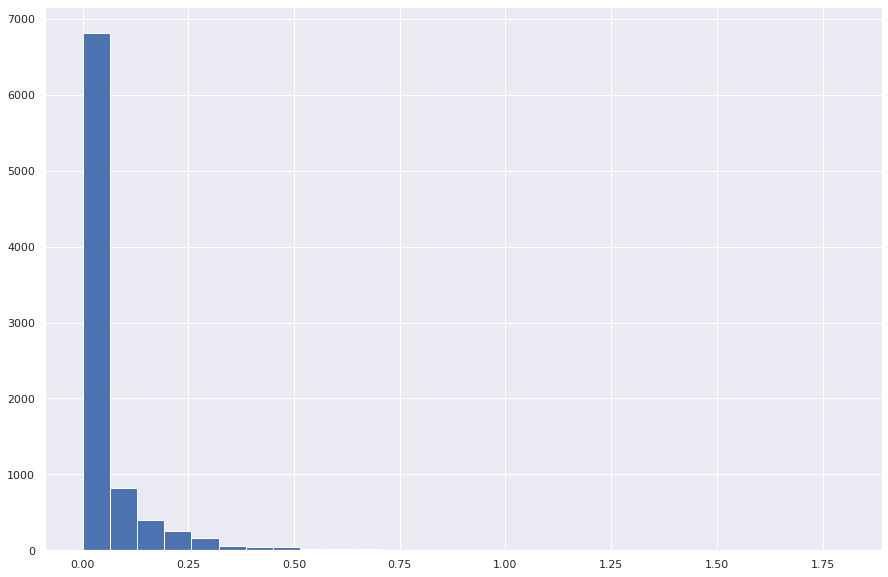

In [42]:
df.groupby('author')['emoji_count'].mean().hist(bins=df['emoji_count'].max())

Again, this histogram is heavily right skewed, showing that authors will generally not overuse emoji in posts the way we observed in the earlier extreme case.

Let's look at the emoji usage behavior of each type.

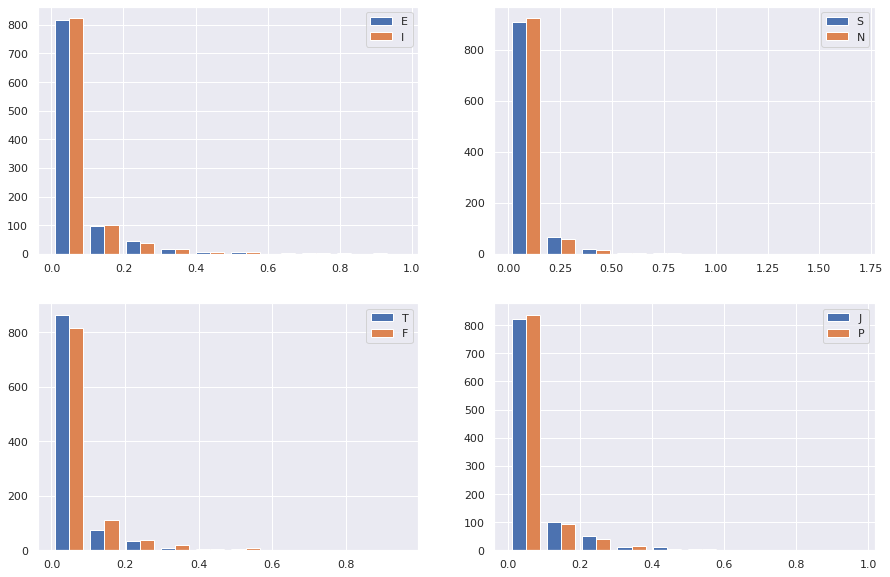

In [43]:
plt.subplot(221)
plt.hist([
    df.loc[lambda x: x['E/I']=='E'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['E/I']=='I'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42)
], label=['E', 'I'])
plt.legend()

plt.subplot(222)
plt.hist([
    df.loc[lambda x: x['S/N']=='S'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['S/N']=='N'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42)
], label=['S', 'N'])
plt.legend()

plt.subplot(223)
plt.hist([
    df.loc[lambda x: x['T/F']=='T'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['T/F']=='F'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42)
], label=['T', 'F'])
plt.legend()

plt.subplot(224)
plt.hist([
    df.loc[lambda x: x['J/P']=='J'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['J/P']=='P'].groupby('author')['emoji_count'].mean().sample(1000, random_state=42)
], label=['J', 'P'])
plt.legend()

We see a slight tendency for Feeling authors to use more emoji per post than Thinking authors.

## Post length

We measure the length of each post in characters. Note that at this point, the post texts have already been modified by prior preprocessing steps. This should especially help with URLs, where very long content IDs shouldn't have any bearing on prediction.

In [44]:
df['length'] = df['post'].str.len()
df.head()

,author,type,E/I,S/N,T/F,J/P,post,post_original,urls,url_count,has_quote,emojis,emoji_count,length
0,0,INFJ,I,N,F,J,'<|url_youtube|>,'http://www.youtube.com/watch?v=qsXHcwe3krw,{'youtube': 1},1,False,NaN,0,16
1,0,INFJ,I,N,F,J,<|url_tumblr|>,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,{'tumblr': 1},1,False,NaN,0,14
2,0,INFJ,I,N,F,J,enfp and intj moments <|url_youtube|> sports...,enfp and intj moments https://www.youtube.com...,{'youtube': 2},2,False,NaN,0,95
3,0,INFJ,I,N,F,J,What has been the most life-changing experienc...,What has been the most life-changing experienc...,NaN,0,False,NaN,0,61
4,0,INFJ,I,N,F,J,<|url_youtube|> <|url_youtube|> On repeat f...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,{'youtube': 2},2,False,NaN,0,63


Let's look at the distribution of post lengths.

In [45]:
df.length.describe()

count    421757.000000
mean        143.673864
std          68.322172
min           1.000000
25%          80.000000
50%         192.000000
75%         199.000000
max         427.000000
Name: length, dtype: float64

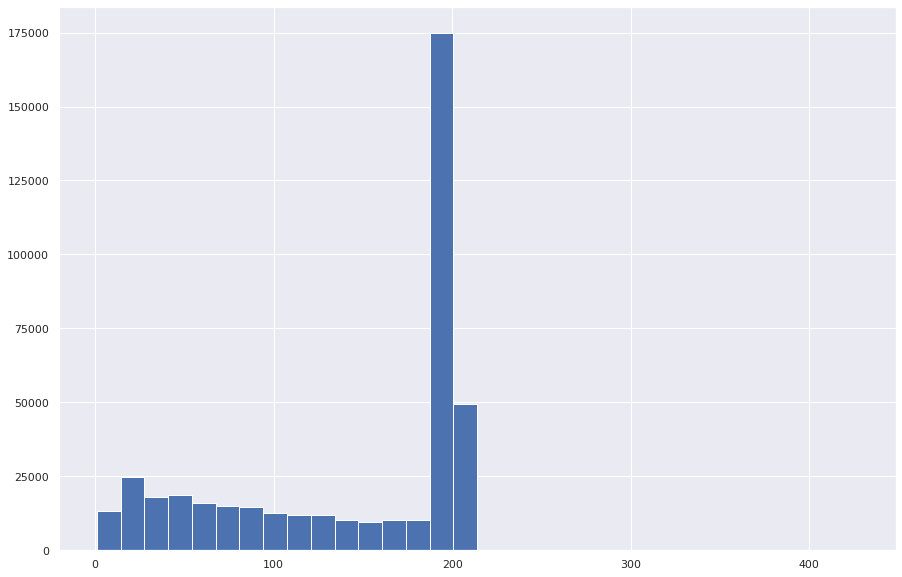

In [46]:
df.length.hist(bins=32)

In [ ]:
df.length.value_counts()

In [48]:
df.loc[df.length==201].sample(random_state=42).post.values

array(['Your husband sounds like the product of his parents. But he is married to you, not his mother. Are you sure he cannot be an ally? Not against his parents, or the neighbour, but an ally in making you...'],
      dtype=object)

We observe a spike in around 200-character-long posts, and then an immediate drop in frequency for posts any longer. This may potentially be an undisclosed detail of the data gathering process, as there are several truncated (with ...) posts in the dataset (as also encountered earlier in the Quotes section).

Nonetheless, we check per-type posting length to see if we can observe any differences between types.

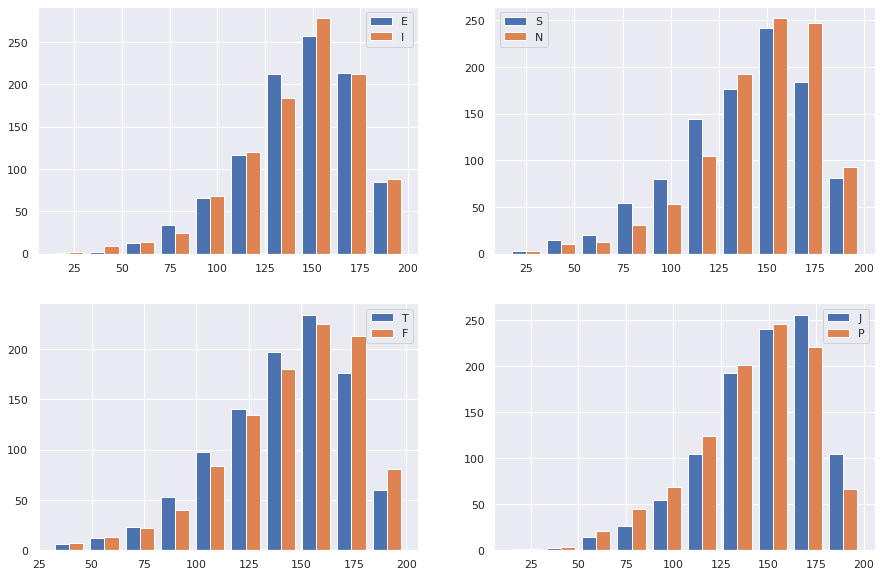

In [49]:
# Per-user mean post length distributions are left-skewed
# Most users average around 150 characters per post
# Thinking users average shorter posts than Feeling users
# Sensing users average shorter posts than Intuitive users

plt.subplot(221)
plt.hist([
    df.loc[lambda x: x['E/I']=='E'].groupby('author')['length'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['E/I']=='I'].groupby('author')['length'].mean().sample(1000, random_state=42)
], label=['E', 'I'])
plt.legend()

plt.subplot(222)
plt.hist([
    df.loc[lambda x: x['S/N']=='S'].groupby('author')['length'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['S/N']=='N'].groupby('author')['length'].mean().sample(1000, random_state=42)
], label=['S', 'N'])
plt.legend()

plt.subplot(223)
plt.hist([
    df.loc[lambda x: x['T/F']=='T'].groupby('author')['length'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['T/F']=='F'].groupby('author')['length'].mean().sample(1000, random_state=42)
], label=['T', 'F'])
plt.legend()

plt.subplot(224)
plt.hist([
    df.loc[lambda x: x['J/P']=='J'].groupby('author')['length'].mean().sample(1000, random_state=42), 
    df.loc[lambda x: x['J/P']=='P'].groupby('author')['length'].mean().sample(1000, random_state=42)
], label=['J', 'P'])
plt.legend()

Per-user mean post length distributions are left-skewed, with most users averaging around 150 characters per post.
Thinking users average shorter posts than Feeling users, while Sensing users average shorter posts than Intuitive users.

## Explicit type self-reporting

Sometimes, people just say what they are! We extract self-reports of MBTI type using a very simple regex that captures the pattern `i am a <type>`.

In [ ]:
df['type_self_reported'] = df['post'].str.extract(r'(?:i\'?m|i\s+am)\s+an?\s+([ei][sn][tf][jp])', flags=re.IGNORECASE)[0].str.upper()
df.loc[df['type_self_reported'].notna()]

In [51]:
print(
    '{:.2%} of posts contain self-reports of MBTI type'.format(df['type_self_reported'].notna().sum()/len(df))
)

0.75% of posts contain self-reports of MBTI type


In [52]:
print(
    '{:.2%} of users self-report their MBTI type'.format(len(df.loc[df['type_self_reported'].notna()].author.unique())/len(df.author.unique()))
)

24.27% of users self-report their MBTI type


However, we find that some users incorrectly self-report their MBTI type by several letters.

In [ ]:
df.loc[lambda x: (x.type_self_reported.notna()) & (x.type!=x.type_self_reported)]

In [54]:
print('{:.2%} of self-report posts are incorrect'.format(
    len(df.loc[lambda x: (x.type_self_reported.notna()) & (x.type!=x.type_self_reported)])/df['type_self_reported'].notna().sum()
))

17.25% of self-report posts are incorrect


We hypothesize that this self-reporting behavior is due to the nature of the data source. PersonalityCafe has a strong emphasis on personality and users' MBTI types, so it follows that users might try to introduce themselves to others by their MBTI type.

Of course, in a real world setting outside of personality-focused forums like PersonalityCafe, it's entirely possible that our MBTI prediction model will not be able to consistently rely on people self-reporting their MBTI type.

(Note: not included anymore) During model training, we'll experiment with and without the inclusion of self-reports as a model feature in order to see how our model might perform without such an obvious hint, and how much its use even affects model performance.

## Aggregating...

Since we're predicting MBTI type per author (i.e. based on their whole post history) and not per post, we'll want the dataset aggregated per author.

In [ ]:
df_agg = df.groupby('author')[['post_original', 'post']].agg(lambda x: '<|sep|>'.join(x)).join(
    df.groupby('author')[['type']].agg(lambda x: x.iloc[0])
).join(
    df.groupby('author')[['url_count', 'emoji_count', 'has_quote']].agg('mean')
).join(
    df.author.value_counts().rename('post_count')
).join(
    df.dropna(subset=['urls']).groupby('author')[['urls']].agg('sum')
).join(
    df.dropna(subset=['emojis']).groupby('author')[['emojis']].agg('sum')
).join(
    df.groupby('author')['type_self_reported'].agg(lambda x: x.any()).replace({False: np.nan})
)
df_agg = df_agg.rename({
    'url_count': 'url_count_mean',
    'emoji_count': 'emoji_count_mean',
    'has_quote': 'quote_count_mean'
}, axis=1)
df_agg

In [56]:
df_agg.isna().sum()

post_original            0
post                     0
type                     0
url_count_mean           0
emoji_count_mean         0
quote_count_mean         0
post_count               0
urls                  3122
emojis                4288
type_self_reported    6570
dtype: int64

## Exporting...

In [58]:
df.head(1000).to_csv('mbti_clean_1000.csv', index=False)
df.to_csv('/content/drive/MyDrive/misc. class files/CSC713M/Project/mbti_clean.csv', index=False)

df_agg.head(1000).to_csv('/content/drive/MyDrive/misc. class files/CSC713M/Project/mbti_agg_clean_1000.csv', index=False)
df_agg.to_csv('mbti_agg_clean.csv', index=False)